In [3]:
# Read and preprocess data

import pandas as pd
df = pd.read_csv(r"C:\Users\mudas\OneDrive\Desktop\BAIS\Text Analytics\assignments\Customer_Service_Questions_Multiclass.csv")
df.head()

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


In [4]:
df.dtypes

question    object
topic       object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5000 non-null   object
 1   topic     5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [6]:
df.isna().sum()

question    0
topic       0
dtype: int64

In [7]:
df.isnull().sum()

question    0
topic       0
dtype: int64

In [8]:
df.groupby('topic').question.count()

topic
Omnichannel               450
Product Availability      833
Product Comparison        806
Product Specifications    839
Returns & Refunds         768
Sales/Promotions          505
Shipping                  799
Name: question, dtype: int64

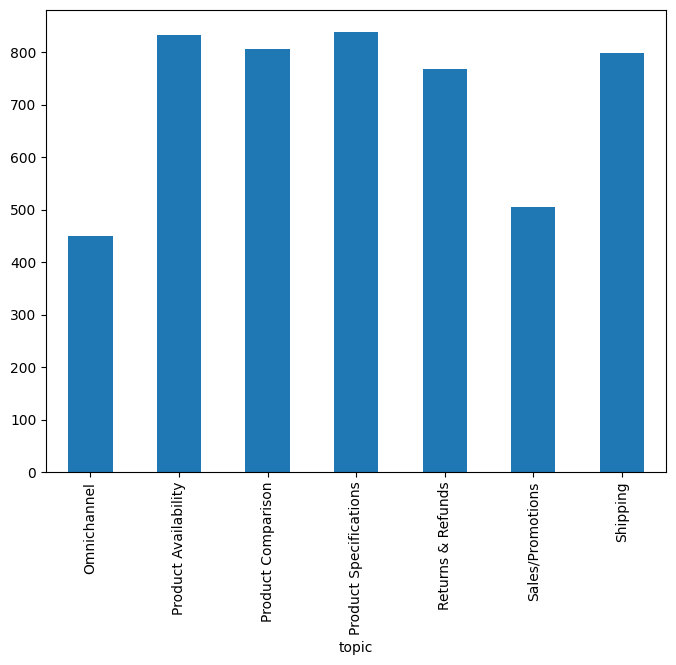

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('topic').question.count().plot.bar(ylim=0)
plt.show()

The classes are a little imbalanced but not too  much

In [10]:
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

I will first clean the text but keep the stop words as I will remove them later for only tf-idf and word2vec. I will keep the stopwords for context for doc vectors.

In [11]:

# 1. Creates an empty list to store cleaned text
clean_questions = []
# 2. Iterates through each text message in the dataset
for t in df['question']:
    # 3. Converts text to lowercase and tokenizes it to extract only alphabetic words
    words = regexp_tokenize(t.lower(), r'[A-Za-z]+')
    # 4. Filters out short words (length ≤ 2) 
    words = [w for w in words if len(w)>2]
    # 5. Lemmatizes each word (reduces to its base form)
    words = [lemmatizer.lemmatize(w) for w in words]
    # 6. Joins the processed words back into a single string and adds to clean_text list
    clean_questions.append(' '.join(words))

In [12]:
df['clean_questions'] = clean_questions
df.head()

,question,topic,clean_questions
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,sign for your email list can select get email ...
1,I'm going to be out of the country for about a...,Shipping,going out the country for about week but befor...
2,I was wondering if you'd be able to overnight ...,Shipping,wa wondering you able overnight jacket item tr...
3,The Swingline electronic stapler (472555) look...,Shipping,the swingline electronic stapler look really g...
4,I think this cosmetic bag would work great for...,Shipping,think this cosmetic bag would work great for h...


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


In [14]:
#!pip install lightgbm. This will be my 3rd model.
import lightgbm as lgb

#### I am using a modular approach using OOP to built the classifiers and the 4 input  vectors. This code block will give me the metrics for all classifiers for each input vector.

In [15]:
class CustomerQueryClassifier:
    def __init__(self, df):
        """
        Initialize the classifier with a dataframe containing customer queries.
        
        Args:
            df: DataFrame with 'clean_questions' and 'topic' columns
        """
        self.df = df
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}  # Dictionary to store trained models
        self.results = {}  # Dictionary to store evaluation results
        self.label_encoder = LabelEncoder()  # For encoding categorical labels
        self.word2vec_model = None  # Will store the Word2Vec model
        
    def prepare_data(self):
        """
        Prepare the dataset by splitting into train/test sets and training a Word2Vec model.
        
        This method:
        1. Splits the data into training and testing sets
        2. Encodes the target labels
        3. Trains a Word2Vec model on all text data
        """
        X = self.df['clean_questions']
        y = self.df['topic']
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data into training and testing sets with stratification
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        

        
    def create_tfidf_word_features(self):
        """
        Create TF-IDF features from individual words.
        
        Returns:
            tuple: (X_train_tfidf, X_test_tfidf) - TF-IDF vectors for training and testing sets
        """
        vectorizer = TfidfVectorizer(
            max_features=5000,     # Limit to top 5000 features
            ngram_range=(1, 1),    # Use only unigrams
            stop_words='english'   # Remove English stop words
        )
        X_train_tfidf = vectorizer.fit_transform(self.X_train)
        X_test_tfidf = vectorizer.transform(self.X_test)
        return X_train_tfidf, X_test_tfidf
        
    def create_tfidf_ngram_features(self):
        """
        Create TF-IDF features from n-grams (sequences of 4-5 words).
        
        Returns:
            tuple: (X_train_ngram, X_test_ngram) - N-gram TF-IDF vectors for training and testing sets
        """
        vectorizer = TfidfVectorizer(
            max_features=5000,     # Limit to top 5000 features
            stop_words='english',  # Remove English stop words
            ngram_range=(4, 5)     # Use 4-grams and 5-grams
        )
        X_train_ngram = vectorizer.fit_transform(self.X_train)
        X_test_ngram = vectorizer.transform(self.X_test)
        return X_train_ngram, X_test_ngram
        

        # Train Word2Vec model on all text data
    def train_word2vec_model(self):
        """Train Word2Vec model separately"""
        if self.word2vec_model is None:
            # Tokenize and remove stopwords
            stop_words = set(stopwords.words('english'))
            sentences = [[word for word in word_tokenize(text.lower()) if word not in stop_words] 
                         for text in self.df['clean_questions']]
            self.word2vec_model = Word2Vec(
                sentences,
                vector_size=100,
                window=4,
                min_count=2,
                workers=8,
                epochs=40
        )
                
    def create_word2vec_features(self):
        """
        Create features using Word2Vec embeddings by averaging word vectors in each document.
        
        Returns:
            tuple: (X_train_word2vec, X_test_word2vec) - Document vectors for training and testing sets
        """
        #ensure the word2vec model is trained
        self.train_word2vec_model()
        #get vectors by averaging word vectors
        def average_word_vec(text):
            """Function to convert a document to a vector by averaging its word vectors"""
            stop_words = set(stopwords.words('english'))
            words = [word for word in word_tokenize(text.lower()) if word not in stop_words]
            vectors = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
            if not vectors:
                return np.zeros(self.word2vec_model.vector_size)  # dynamically get size
            return np.mean(vectors, axis=0)  # Average the word vectors
            
        X_train_word2vec = np.array([average_word_vec(text) for text in self.X_train])
        X_test_word2vec = np.array([average_word_vec(text) for text in self.X_test])
        return X_train_word2vec, X_test_word2vec
    def create_doc2vec_features(self):
        """
        Create features using Doc2Vec, which learns document-level embeddings.
        
        Returns:
            tuple: (X_train_doc2vec, X_test_doc2vec) - Document vectors for training and testing sets
        """
        # Create tagged documents for Doc2Vec training
        tagged_docs = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[i]) 
                      for i, doc in enumerate(self.X_train)]
        
        # Initialize and train Doc2Vec model
        model = Doc2Vec(vector_size=100,window=4, min_count=2,workers = 4, epochs=40)
        model.build_vocab(tagged_docs)
        model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
        
        # Generate document vectors for training and testing sets
        X_train_doc2vec = np.array([model.dv[i] for i in range(len(self.X_train))])
        X_test_doc2vec = np.array([model.infer_vector(word_tokenize(doc.lower())) 
                                  for doc in self.X_test])
        return X_train_doc2vec, X_test_doc2vec
        
    def train_and_evaluate(self, X_train, X_test, feature_type):
        """
        Train and evaluate both Decision Tree and XGBoost classifiers on the given features.
        
        Args:
            X_train: Training features
            X_test: Testing features
            feature_type: String describing the feature type (for reporting)
        """
        # Train and evaluate Decision Tree classifier
        dt_clf = DecisionTreeClassifier(random_state=42)
        dt_clf.fit(X_train, self.y_train)
        dt_y_pred = dt_clf.predict(X_test)
        
        # Train and evaluate XGBoost classifier
        xgb_clf = xgb.XGBClassifier(
            objective='multi:softmax',  # Multiclass classification
            num_class=len(np.unique(self.y_train)),  # Number of classes
            random_state=42,
            n_estimators=100,  # Number of trees
            learning_rate=0.1, # Learning rate
            reg_alpha=0.1,         # L1 regularization
            reg_lambda=0.1       # L2 regularization
        )
        xgb_clf.fit(X_train, self.y_train)
        xgb_y_pred = xgb_clf.predict(X_test)


        # Train and evaluate LightGBM classifier
        lgb_clf = lgb.LGBMClassifier(
            objective='multiclass',
            num_class=len(np.unique(self.y_train)),
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            min_child_samples=20,  # Minimum number of samples required in a child
            min_split_gain=0.0,    # Minimum gain to make a split
            verbose=-1,             # Reduce verbosity
            reg_alpha=0.1,         # L1 regularization
            reg_lambda=0.1        # L2 regularization
        )
        lgb_clf.fit(X_train, self.y_train)
        lgb_y_pred = lgb_clf.predict(X_test)
        
        # Store evaluation results for Decision Tree
        self.results[f"{feature_type} - Decision Tree"] = {
            'accuracy': accuracy_score(self.y_test, dt_y_pred),
            'report': classification_report(self.y_test, dt_y_pred, output_dict=True)
        }
        
        # Store evaluation results for XGBoost
        self.results[f"{feature_type} - XGBoost"] = {
            'accuracy': accuracy_score(self.y_test, xgb_y_pred),
            'report': classification_report(self.y_test, xgb_y_pred, output_dict=True)
        }
        

        # Store evaluation results for LightGBM
        self.results[f"{feature_type} - LightGBM"] = {
            'accuracy': accuracy_score(self.y_test, lgb_y_pred),
            'report': classification_report(self.y_test, lgb_y_pred, output_dict=True)
        }
        # Store the trained models
        self.models[f"{feature_type} - Decision Tree"] = dt_clf
        self.models[f"{feature_type} - XGBoost"] = xgb_clf
        self.models[f"{feature_type} - LightGBM"] = lgb_clf
        

    def run_all_models(self):
        """
        Run all feature extraction methods and train models on each feature set.
        
        This method:
        1. Creates different feature representations (TF-IDF, Word2Vec, Doc2Vec)
        2. Trains and evaluates models on each feature set
        """
        # TF-IDF Word Features
        X_train_tfidf, X_test_tfidf = self.create_tfidf_word_features()
        self.train_and_evaluate(X_train_tfidf, X_test_tfidf, 'TF-IDF Words')
        
        # TF-IDF N-gram Features
        X_train_ngram, X_test_ngram = self.create_tfidf_ngram_features()
        self.train_and_evaluate(X_train_ngram, X_test_ngram, 'TF-IDF N-grams')
        
        # Word2Vec Features
        X_train_word2vec, X_test_word2vec = self.create_word2vec_features()
        self.train_and_evaluate(X_train_word2vec, X_test_word2vec, 'Word2Vec')
        
        # Doc2Vec Features
        X_train_doc2vec, X_test_doc2vec = self.create_doc2vec_features()
        self.train_and_evaluate(X_train_doc2vec, X_test_doc2vec, 'Doc2Vec')
        
    def print_results(self):
        """
        Create and display a pandas DataFrame showing performance metrics for all models.
        
        Displays accuracy, precision, recall, and F1-score for each model.
        """
        # Create lists to store the results
        results_data = []
        
        for model_name, result in self.results.items():
            report = result['report']
            accuracy = result['accuracy']
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1 = report['weighted avg']['f1-score']
            
            # Add results to list
            results_data.append({
                'Model': model_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        
        # Create DataFrame
        results_df = pd.DataFrame(results_data)
        
        # Format numeric columns to 4 decimal places
        numeric_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        results_df[numeric_columns] = results_df[numeric_columns].round(4)
        

        # Display the DataFrame
        print("\nModel Performance Summary:")
        
        return results_df

In [17]:
# Initialize the classifier with your DataFrame
classifier = CustomerQueryClassifier(df)

# Prepare the data 
classifier.prepare_data()

# Run all models
classifier.run_all_models()

# Get and display results as DataFrame
results_df = classifier.print_results()
display(results_df)


Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1-Score
0,TF-IDF Words - Decision Tree,0.915,0.9156,0.915,0.9151
1,TF-IDF Words - XGBoost,0.937,0.9386,0.937,0.9371
2,TF-IDF Words - LightGBM,0.938,0.9394,0.938,0.9380
3,TF-IDF N-grams - Decision Tree,0.701,0.8859,0.701,0.7288
4,TF-IDF N-grams - XGBoost,0.590,0.8808,0.590,0.6222
5,TF-IDF N-grams - LightGBM,0.326,0.8103,0.326,0.2980
6,Word2Vec - Decision Tree,0.842,0.8436,0.842,0.8421
7,Word2Vec - XGBoost,0.941,0.9418,0.941,0.9410
8,Word2Vec - LightGBM,0.947,0.9479,0.947,0.9469
9,Doc2Vec - Decision Tree,0.325,0.3309,0.325,0.3259


## LightGBM with Word2Vec performs the best overall with highest accuracy and F1 score 


In [18]:
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df 

,Model,Accuracy,Precision,Recall,F1-Score
8,Word2Vec - LightGBM,0.947,0.9479,0.947,0.9469
7,Word2Vec - XGBoost,0.941,0.9418,0.941,0.9410
2,TF-IDF Words - LightGBM,0.938,0.9394,0.938,0.9380
1,TF-IDF Words - XGBoost,0.937,0.9386,0.937,0.9371
0,TF-IDF Words - Decision Tree,0.915,0.9156,0.915,0.9151
6,Word2Vec - Decision Tree,0.842,0.8436,0.842,0.8421
3,TF-IDF N-grams - Decision Tree,0.701,0.8859,0.701,0.7288
11,Doc2Vec - LightGBM,0.605,0.6219,0.605,0.6056
4,TF-IDF N-grams - XGBoost,0.590,0.8808,0.590,0.6222
10,Doc2Vec - XGBoost,0.577,0.5940,0.577,0.5780


### My FINAL MODEL - Word2Vec - LIGHTGBM with stopword removal and lemmatization was the best.
For experimentation , I tried word2vec and doc2vec with and without stop words removal and lemmatization. 
 - Removing stop words for doc2vec worsened its performance but keeping it for word2vec improved results on the new test data that I generate later. 
 - However, the metrics were lower for word2vec as well with removal of stopwords.
 - Word2vec-lightgbm still was the best performer when I kept stopwords but that model performed worse on new test data. Seemingly, the model was overfitting for the product specification class. 



Further, I also tried different hyperparams , tuning the learning rate, implementing max depth, changing window, epochs and regularization .

doc2 vec did not perform well possibly because it needs longer context and the question are short text.

## Explainable AI (LIME/SHAP)

In [66]:
# Install required packages
#!pip install lime shap

In [20]:
import lime
import lime.lime_tabular

In [21]:

# Get the best model and its features
best_model = classifier.models['Word2Vec - LightGBM']
X_train_word2vec, X_test_word2vec = classifier.create_word2vec_features()


In [22]:
class_names=classifier.label_encoder.classes_
class_names


array(['Omnichannel', 'Product Availability', 'Product Comparison',
       'Product Specifications', 'Returns & Refunds', 'Sales/Promotions',
       'Shipping'], dtype=object)

In [23]:

# LIME Analysis
# Create a LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_word2vec,
    mode="classification",
    training_labels=classifier.y_train,
    feature_names=[f"dim_{i}" for i in range(X_train_word2vec.shape[1])],
    class_names = classifier.label_encoder.classes_

)

<Figure size 1000x600 with 0 Axes>

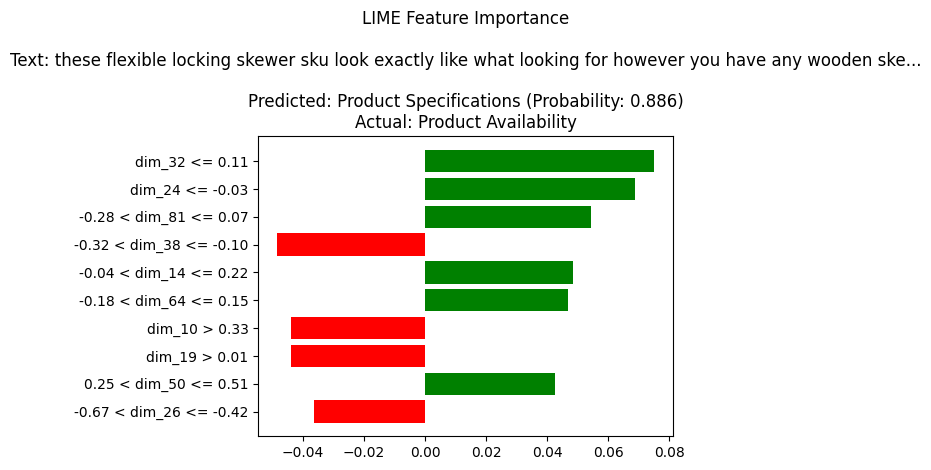


Detailed Explanation:
--------------------------------------------------------------------------------
Full Text: these flexible locking skewer sku look exactly like what looking for however you have any wooden skewer sometimes just want throw the mess away instead having wash them
True class: Product Availability
Predicted class: Product Specifications

Predicted probabilities for all classes:
Omnichannel: 0.0006
Product Availability: 0.0532
Product Comparison: 0.0578
Product Specifications: 0.8860
Returns & Refunds: 0.0012
Sales/Promotions: 0.0004
Shipping: 0.0008


In [24]:
# Get explanation for a sample instance
sample_idx = 32  

# Get the actual text and classes
sample_text = classifier.X_test.iloc[sample_idx]
true_class = classifier.y_test[sample_idx]
true_class_name = classifier.label_encoder.inverse_transform([true_class])[0]

# Get prediction
pred_proba = best_model.predict_proba(X_test_word2vec[sample_idx].reshape(1, -1))[0]
pred_class = pred_proba.argmax()
pred_class_name = classifier.label_encoder.inverse_transform([pred_class])[0]

# Get explanation
exp = explainer.explain_instance(
    X_test_word2vec[sample_idx], 
    best_model.predict_proba,
    num_features=10,
    top_labels=1  # Get explanation for top predicted class
)

# Get the explanation for the top predicted class (should be the first one)
top_label = exp.available_labels()[0]

# Plot LIME explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure(label=top_label)  # Specify the label explicitly
plt.title(f"LIME Feature Importance\n\nText: {sample_text[:100]}...\n\n" + 
          f"Predicted: {pred_class_name} (Probability: {pred_proba[pred_class]:.3f})\n" + 
          f"Actual: {true_class_name}")
plt.tight_layout()
plt.show()

# Print detailed text explanation
print("\nDetailed Explanation:")
print("-" * 80)
print(f"Full Text: {sample_text}")
print(f"True class: {true_class_name}")
print(f"Predicted class: {pred_class_name}")


print("\nPredicted probabilities for all classes:")
for i, prob in enumerate(pred_proba):
    class_name = classifier.label_encoder.inverse_transform([i])[0]
    print(f"{class_name}: {prob:.4f}")

In [25]:
exp.show_in_notebook(show_table=True)


### SHAP

In [26]:
# Implement SHAP analysis
import shap


In [27]:
%timeit
# Get the Word2Vec features and model
X_train_word2vec, X_test_word2vec = classifier.create_word2vec_features()
best_model = classifier.models['Word2Vec - LightGBM']

# Take samples from both train and test sets
np.random.seed(42)
train_sample_size = 4000  # 4000 for training
test_sample_size = 50   # 100 for testing

# Sample from training set
train_indices = np.random.choice(X_train_word2vec.shape[0], train_sample_size, replace=False)
X_train_sample = X_train_word2vec[train_indices]

# Sample from test set
test_indices = np.random.choice(X_test_word2vec.shape[0], test_sample_size, replace=False)
X_test_sample = X_test_word2vec[test_indices]

# Calculate SHAP values using training sample as background
explainer = shap.TreeExplainer(best_model, X_train_sample) #using treeexplainer as I am using LightGBM which is tree based model. It is more fast and efficient
shap_values = explainer.shap_values(X_test_sample)


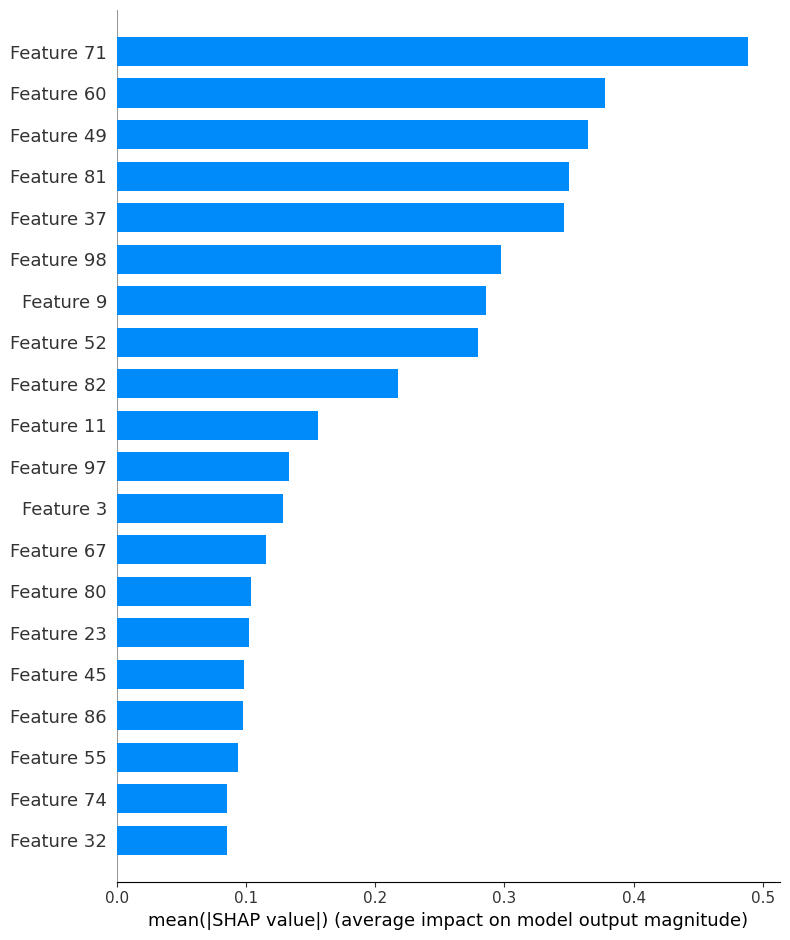

In [28]:
shap.summary_plot(shap_values[0], X_test_sample, plot_type="bar")

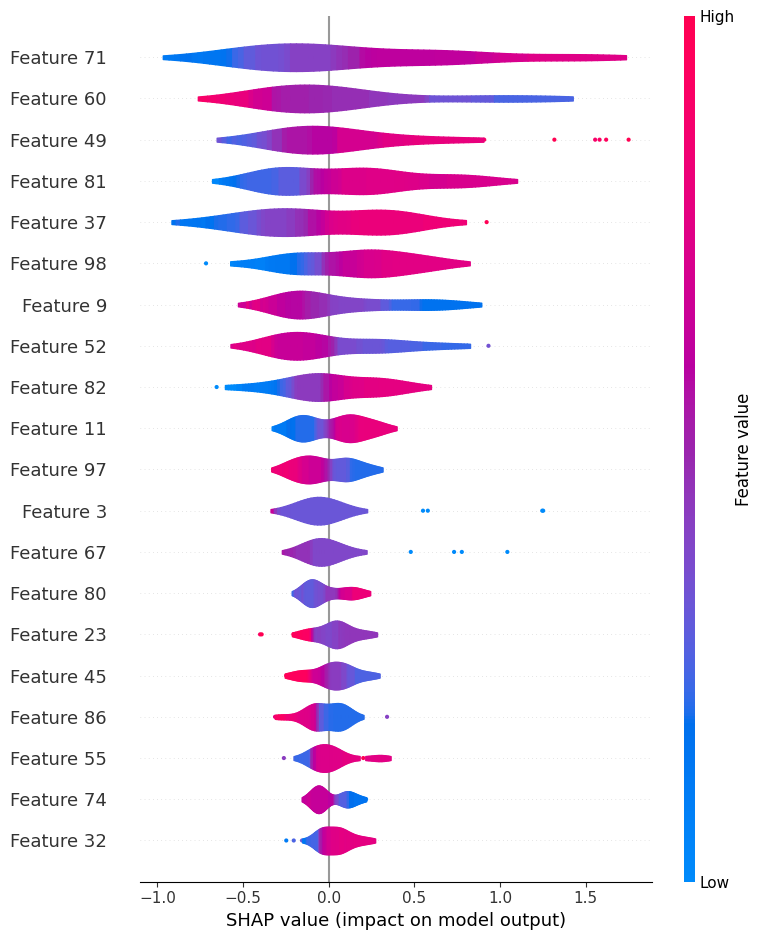

In [29]:

# Create violin plot
shap.summary_plot(shap_values[0], X_test_sample, plot_type="violin")


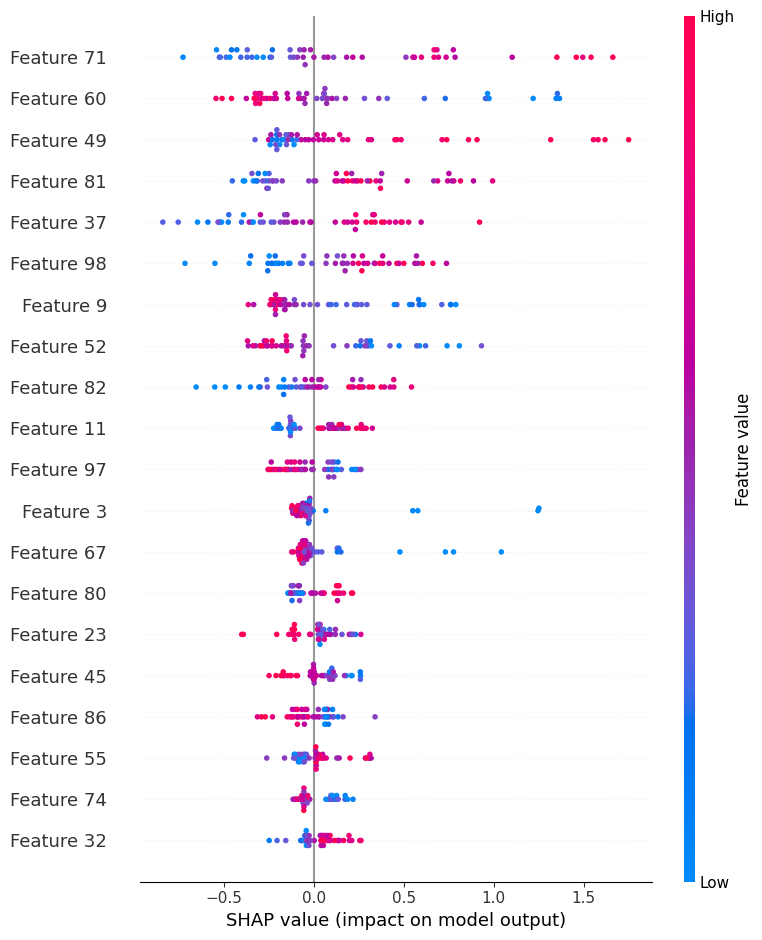

In [30]:
shap.summary_plot(shap_values[0], X_test_sample) 



#### The violin plot shows the distribution of feature impacts, while the beeswarm plot shows both the magnitude and direction of feature impacts along with their distributions. These plots together provide a comprehensive global view of how my model uses different features to make predictions.Since we are using word embeddings , we wont get word level mappings.

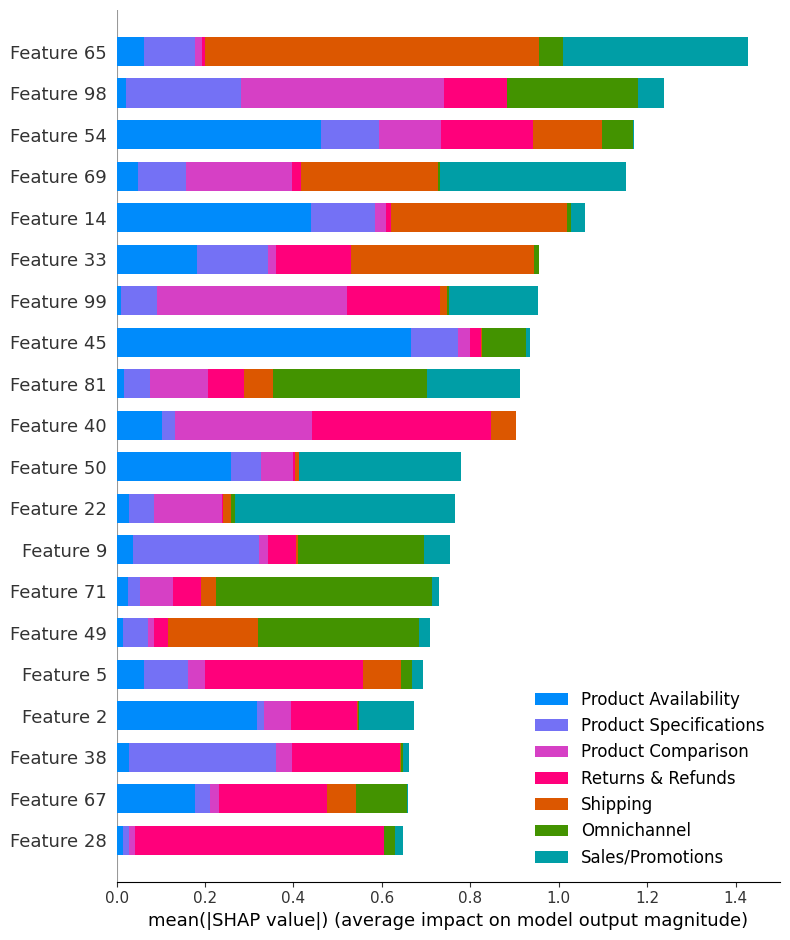

<Figure size 640x480 with 0 Axes>

In [ ]:
# Global Feature Importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_word2vec, 
                 class_names=classifier.label_encoder.classes_,
                 plot_type="bar",
                 title="Global Feature Importance Across All Topics")
plt.tight_layout()
plt.show()

### Prediction for 10 User Created Queries 

In [38]:
# Step 1: Create test queries with their actual topics
test_data = {
    'question': [
        "Can I get a refund if I return this printer within 30 days?",
        "What's the difference between the basic and premium office chairs?",
        "Do you have any ongoing sales on ergonomic keyboards?",
        "How long will shipping take to California?",
        "Is the Logitech MX Master 3 mouse in stock?",
        "Can I buy online and pick up in your downtown store?",
        "What are the dimensions of the standing desk?",
        "Will there be a Black Friday sale this year?",
        "How does the HP printer compare to the Epson one?",
        "Can you tell me if this paper is compatible with laser printers?"
    ],
    'topic': [
        "Returns & Refunds",
        "Product Comparison",
        "Sales/Promotions",
        "Shipping",
        "Product Availability",
        "Omnichannel",
        "Product Specifications",
        "Sales/Promotions",
        "Product Comparison",
        "Product Specifications"
    ]
}

test_df = pd.DataFrame(test_data)

In [39]:
test_df

,question,topic
0,Can I get a refund if I return this printer wi...,Returns & Refunds
1,What's the difference between the basic and pr...,Product Comparison
2,Do you have any ongoing sales on ergonomic key...,Sales/Promotions
3,How long will shipping take to California?,Shipping
4,Is the Logitech MX Master 3 mouse in stock?,Product Availability
5,Can I buy online and pick up in your downtown ...,Omnichannel
6,What are the dimensions of the standing desk?,Product Specifications
7,Will there be a Black Friday sale this year?,Sales/Promotions
8,How does the HP printer compare to the Epson one?,Product Comparison
9,Can you tell me if this paper is compatible wi...,Product Specifications


In [40]:
# Clean the test queries using the same preprocessing steps
def preprocess_queries(queries):
    clean_queries = []
    for t in queries:
        words = regexp_tokenize(t.lower(), r'[A-Za-z]+')
        words = [w for w in words if len(w)>1]
        words = [lemmatizer.lemmatize(w) for w in words]
        clean_queries.append(' '.join(words))
    return clean_queries

test_df['clean_questions'] = preprocess_queries(test_df['question'])

In [41]:
# Get Word2Vec features for test queries
def get_word2vec_features(text, word2vec_model):
    words = word_tokenize(text.lower())
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if not vectors:
        return np.zeros(100)
    return np.mean(vectors, axis=0)

# Transform test queries to Word2Vec features
X_test_new = np.array([get_word2vec_features(text, classifier.word2vec_model) 
                       for text in test_df['clean_questions']])

In [42]:
# Get the best model (Word2Vec - LightGBM)
best_model = classifier.models['Word2Vec - LightGBM']

# Make predictions
predictions = best_model.predict(X_test_new)

# Convert numeric predictions back to category labels
predicted_labels = classifier.label_encoder.inverse_transform(predictions)

# Add predictions to the DataFrame
test_df['predicted_category'] = predicted_labels

In [43]:
test_df

,question,topic,clean_questions,predicted_category
0,Can I get a refund if I return this printer wi...,Returns & Refunds,can get refund if return this printer within day,Returns & Refunds
1,What's the difference between the basic and pr...,Product Comparison,what the difference between the basic and prem...,Product Comparison
2,Do you have any ongoing sales on ergonomic key...,Sales/Promotions,do you have any ongoing sale on ergonomic keyb...,Sales/Promotions
3,How long will shipping take to California?,Shipping,how long will shipping take to california,Returns & Refunds
4,Is the Logitech MX Master 3 mouse in stock?,Product Availability,is the logitech mx master mouse in stock,Product Comparison
5,Can I buy online and pick up in your downtown ...,Omnichannel,can buy online and pick up in your downtown store,Omnichannel
6,What are the dimensions of the standing desk?,Product Specifications,what are the dimension of the standing desk,Product Specifications
7,Will there be a Black Friday sale this year?,Sales/Promotions,will there be black friday sale this year,Sales/Promotions
8,How does the HP printer compare to the Epson one?,Product Comparison,how doe the hp printer compare to the epson one,Product Comparison
9,Can you tell me if this paper is compatible wi...,Product Specifications,can you tell me if this paper is compatible wi...,Product Comparison


As we see there are some misclassifications on the new test data. When I tried keeping stopwords for word 2vec, these results were worse with more misclassifications. Hence, I removed stopwords for tf-idf and word2vec but kept them for doc vec only. 

### EXTRA 
##### Since, the performance of TF-idf -lightgbm is close to word2vec lightgbm model, I can have used Tf-idf lightgbm model instead so I can get word level mapping using explainable AI. 

In [50]:
# Get the TF-IDF features and model
X_train_tfidf, X_test_tfidf = classifier.create_tfidf_word_features()
tfidf_words_lgbm = classifier.models['TF-IDF Words - LightGBM']

# Create a new vectorizer with the same parameters as used in the class
vectorizer = TfidfVectorizer(
    max_features=5000,     
    ngram_range=(1, 1),    
    stop_words='english'   
)

# Fit the vectorizer on the same training data to get the same features
vectorizer.fit(classifier.X_train)
feature_names = vectorizer.get_feature_names_out()

# Convert sparse matrix to dense array
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Take samples from both train and test sets
np.random.seed(42)
train_sample_size = 4000  
test_sample_size = 50   

# Sample from training set
train_indices = np.random.choice(X_train_tfidf_dense.shape[0], train_sample_size, replace=False)
X_train_sample = X_train_tfidf_dense[train_indices]

# Sample from test set
test_indices = np.random.choice(X_test_tfidf_dense.shape[0], test_sample_size, replace=False)
X_test_sample = X_test_tfidf_dense[test_indices]

# Calculate SHAP values using training sample as background
explainer = shap.TreeExplainer(tfidf_words_lgbm, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)


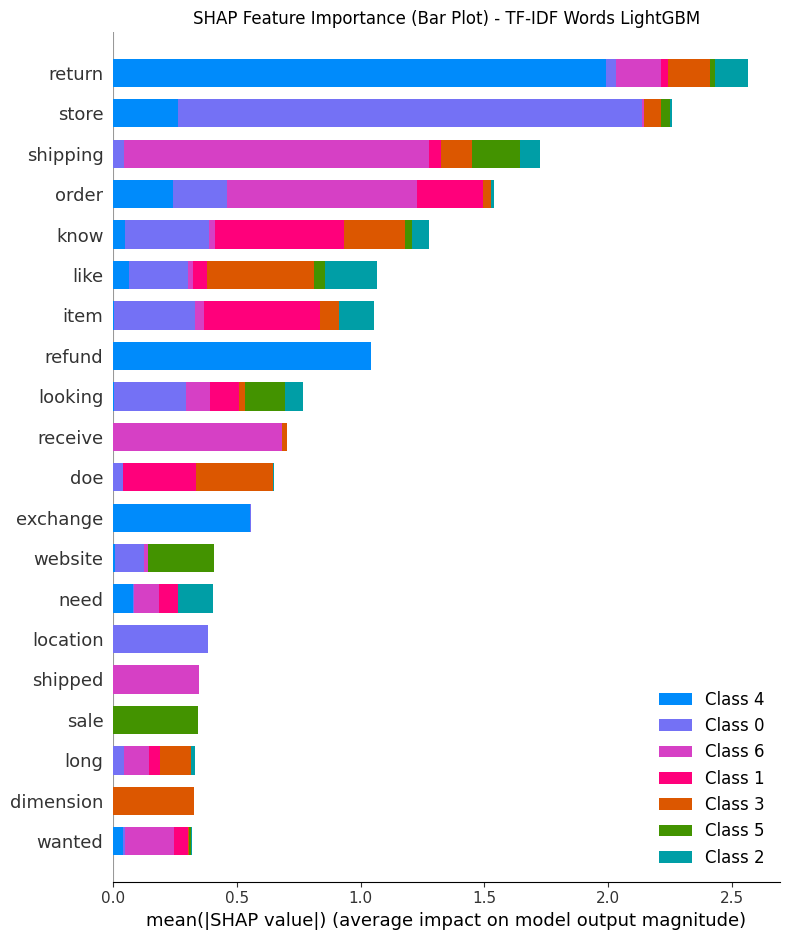

In [55]:

# Create figure for better visualization
plt.figure(figsize=(15, 10))
# Bar plot - Mean absolute SHAP values
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", 
                 feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance (Bar Plot) - TF-IDF Words LightGBM")
plt.tight_layout()
plt.show()
